# Compare Network Performance
Load in the results from the model trainings, and evaluate their performance

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from jcesr_ml.benchmark import load_benchmark_data
from sklearn.metrics import mean_absolute_error
from pathlib import Path
from tqdm import tqdm
from glob import glob
import pickle as pkl
import pandas as pd
import numpy as np
import json
import os

In /homes/lward/miniconda3/envs/solv_ml/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In /homes/lward/miniconda3/envs/solv_ml/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The verbose.level rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In /homes/lward/miniconda3/envs/solv_ml/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.


## Load in the Test Data
We are going to use it to validate our models

In [2]:
_, test_data = load_benchmark_data()

In [3]:
baseline_water = (test_data['sol_water'] - test_data['sol_water'].mean()).abs().mean()
print(f'Baseline: {baseline_water:.2f}')

Baseline: 3.28


## Score All Models
Run all models on the test sets, store results in DataFrame

In [4]:
models = glob(os.path.join('networks', '**', 'test_results.csv'), recursive=True)

In [5]:
def score_model(path):
    """Given a log file, parse the settings for the network and the epoch time / ending val_loss
    
    Args:
        path (str): Get the path 
    """
    
    # Get the metadata from the `config.json` file
    path = Path(path)
    with open(path.parent / 'config.json') as fp:
        metadata = json.load(fp)
    metadata['path'] = path.parent
       
    # Score the model on the target variable
    with open(path.parent.parent / 'options.json') as fp:
        options = json.load(fp)
    output = options['output_props']
    metadata['output_variables'] = output
    
    # Load in the log
    log = pd.read_csv(path.parent / 'train_log.csv')
    metadata['epochs'] = len(log)
    metadata['median_epoch_time'] = np.percentile(log['epoch_time'], 50)
    metadata['total_time'] = log['epoch_time'].sum()
    metadata['best_loss'] = log['val_loss'].min()
    metadata['best_loss_epoch'] = log['val_loss'].idxmin()
    
    # Check whether the network had finished training
    metadata['finished'] = os.path.isfile(path.parent.joinpath('finished'))
    
    # Get the scores on the test set
    directory = path.parent
    test_data = pd.read_csv(path)
    pred_cols = [f'{x}_pred' for x in output]
    metadata['mae_all_outputs'] = mean_absolute_error(test_data[pred_cols], test_data[output])

    # Get the MAE on water only
    metadata['mae_water'] = mean_absolute_error(test_data['sol_water_pred'], test_data['sol_water'])
    return metadata

In [6]:
results = [score_model(x) for x in tqdm(models)]

100%|██████████| 35/35 [00:01<00:00, 34.55it/s]


In [7]:
results = pd.DataFrame(results)

In [8]:
results.sort_values('mae_water', ascending=True).to_csv('mpnn-results.csv', index=False)

## Evaluate the Models
Make sure that our models are working as expected

In [9]:
results.sort_values('mae_water', ascending=True)[['name', 'mae_water', 'finished', 'total_time',
                                                  'num_epochs', 'batch_size', 'median_epoch_time']].head(10)

,name,mae_water,finished,total_time,num_epochs,batch_size,median_epoch_time
33,dielectric-constant-softplus-charges,0.297692,False,102836.882012,2048,512,52.730240
2,dielectric-constant-softplus_no-acn,0.433976,False,352534.230792,8192,512,43.033689
5,dielectric-constant-softplus,0.434499,False,357012.966743,8192,512,43.573144
25,single-task,0.440289,False,351152.459489,8192,512,42.852508
6,dielectric-constant-softplus,0.445563,False,178162.320187,4096,512,43.500324
12,dielectric-constant-softplus-mpnn-charges,0.453259,False,101259.042081,2048,512,51.491894
0,dielectric-constant-softplus_no-acn,0.458205,False,101053.484549,2048,512,51.398600
7,dielectric-constant-softplus,0.463498,False,103009.728757,2048,512,52.893041
27,single-task,0.465991,False,175193.082227,4096,512,42.765704
13,multi-task_multi-dense,0.469132,False,106477.289617,2048,512,54.935757


In [10]:
results.sort_values('mae_water', ascending=True).query('num_epochs==512')\
    [['name', 'mae_water', 'finished', 'total_time', 
      'epochs', 'batch_size', 'median_epoch_time']]

,name,mae_water,finished,total_time,epochs,batch_size,median_epoch_time
30,single-task,0.479564,False,36785.391741,512,64,77.226250
19,single-task,0.488401,False,28704.932694,512,128,59.790030
22,single-task,0.505844,False,52326.941459,512,32,108.762145
23,single-task,0.516048,False,27507.327657,512,256,58.656244
24,single-task,0.521147,False,21911.400739,512,512,42.802744
28,single-task,0.532316,False,25307.004952,512,512,52.902063


### Plot the Learning as Function of Epoch
Look for anomalous behavior

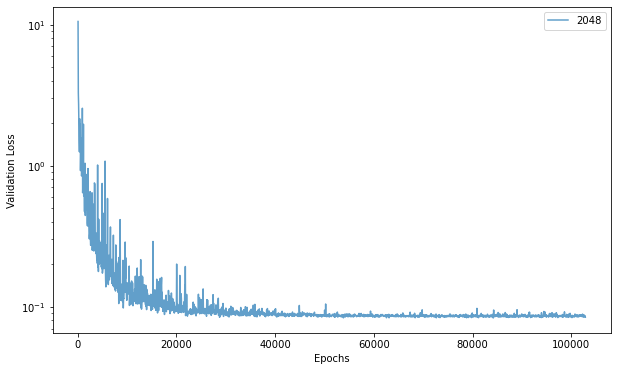

In [11]:
fig, ax = plt.subplots()

for _, f in results.query('name=="dielectric-constant-softplus-charges"').iterrows():
    log = pd.read_csv(os.path.join(f['path'], 'train_log.csv'))
    ax.semilogy(log['epoch_time'].cumsum(), log['val_loss'], label=f['num_epochs'], alpha=0.7)

ax.set_ylabel('Validation Loss')
ax.set_xlabel('Epochs')
ax.legend()
fig.set_size_inches(10, 6)

single-task best loss after 512 epochs was at 83 epochs: 0.2898043096065521
single-task best loss after 512 epochs was at 106 epochs: 0.06629014760255814
single-task best loss after 512 epochs was at 166 epochs: 0.331807017326355
single-task best loss after 512 epochs was at 94 epochs: 0.3860921561717987
single-task best loss after 512 epochs was at 182 epochs: 0.4341830015182495
single-task best loss after 512 epochs was at 44 epochs: 0.05946532264351845


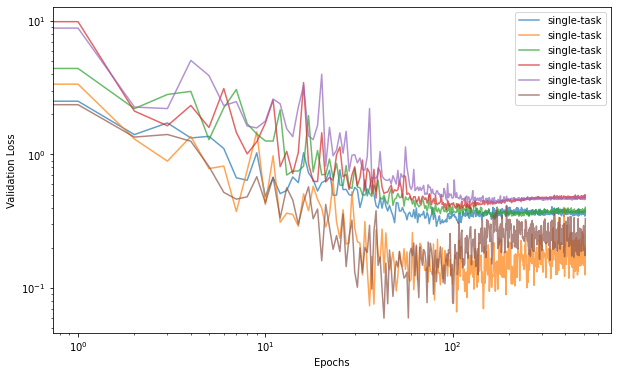

In [12]:
fig, ax = plt.subplots()

for _, f in results.query('num_epochs==512').iterrows():
    log = pd.read_csv(os.path.join(f['path'], 'train_log.csv'))
    print('{} best loss after {} epochs was at {} epochs:'.format(f['name'], len(log), log['val_loss'].idxmin() + 1),
              log['val_loss'].min())
    ax.loglog(log['epoch'], log['val_loss'], label=f['name'], alpha=0.7)

ax.set_ylabel('Validation Loss')
ax.set_xlabel('Epochs')
#ax.set_xlim(0, 2000)
ax.legend()
fig.set_size_inches(10, 6)